## Un'esplorazione della generazione di token

Luca Mari, gennaio 2025  

Quest'opera è distribuita con <a href="http://creativecommons.org/licenses/by-nc-sa/4.0" target="_blank">Licenza Creative Commons Attribuzione - Non commerciale - Condividi allo stesso modo 4.0 Internazionale</a>.  
<img src="https://creativecommons.it/chapterIT/wp-content/uploads/2021/01/by-nc-sa.eu_.png" width="100">

**Obiettivo**: comprendere la logica con cui vengono generati i token che costituiscono una risposta prodotta da un transformer a una richiesta data.  
**Precompetenze**: basi di Python.

> Per eseguire questo notebook, supponiamo con VSCode, occorre:
> * installare un interprete Python
> * scaricare da https://code.visualstudio.com/download e installare VSCode
> * eseguire VSCode e attivare le estensioni per Python e Jupyter
> * ancora in VSCode:
>     * creare una cartella di lavoro e renderla la cartella corrente
>     * copiare nella cartella i file di questa attività: [decode.ipynb](decode.ipynb)
>     * aprire il notebook `decode.ipynb`
>     * creare un ambiente virtuale locale Python (Select Kernel | Python Environments | Create Python Environment | Venv, e scegliere un interprete Python):
>     * installare i moduli Python richiesti, eseguendo dal terminale:  
>         `pip install torch transformers`

Come è ben noto, i transformer rispondono alle richieste che ricevono operando con una logica autoregressiva, generando cioè un token per volta, in modo iterativo. Esploriamo qui le ultime fasi di questo processo, per mostrare come da un'elaborazione realizzata su vettori di numeri si torni a token e quindi a testi.  
Per le nostre prove usiamo https://huggingface.co/google/gemma-2-2b-it, uno _Small Language Model_ che eseguiremo in locale ma già piuttosto sofisticato, con il suoi 2.61B parametri (alla prima esecuzione sarà dunque necessario attendere che il modello sia scaricato dal sito di Hugging Face: è un file di circa 5 GB che viene copiato in una cache locale).

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pprint import pprint
import logging
from transformers import logging as transformers_logging

logging.basicConfig(level=logging.ERROR)
transformers_logging.set_verbosity_error()

model_id = "google/gemma-2-2b-it"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)

print(f'Stiamo usando un transformer con un vocabolario di {tokenizer.vocab_size} token')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Stiamo usando un transformer con un vocabolario di 256000 token


Specifichiamo la richiesta e tokenizziamola.

In [2]:
prompt = "Come si chiama la capitale della Francia? (non usare caratteri di enfatizzazione)"
print(f'\nLa richiesta: {prompt}')

inputs = tokenizer(prompt, return_tensors="pt")
print('\nCiò che produce il tokenizer:')
pprint(inputs)

print(f"\nPer controllo, decodifichiamo la richiesta: {tokenizer.decode(inputs['input_ids'][0])}") # type: ignore


La richiesta: Come si chiama la capitale della Francia? (non usare caratteri di enfatizzazione)

Ciò che produce il tokenizer:
{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'input_ids': tensor([[     2,  13132,   1804, 104803,    683,  66831,   4748,  35872, 235336,
            591,   6357,  96459, 232044,    751, 150474, 201222, 235275]])}

Per controllo, decodifichiamo la richiesta: <bos>Come si chiama la capitale della Francia? (non usare caratteri di enfatizzazione)


Inviamo ora la richiesta tokenizzata al transformer, indicando che dovrebbe produrre non solo i token della risposta ma anche i logits per ogni token generato, in modo da consentirci di comprendere meglio il modo con cui i token stessi sono scelti.

In [16]:
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_length=500,                     # numero massimo di token nella risposta
        num_return_sequences=1,             # numero di risposte da generare
        output_scores=True,                 # produce anche i logits per ogni token generato
        return_dict_in_generate=True,       # produce un dizionario invece di una lista
        do_sample=True,                     # abilita la generazione casuale
        temperature=1.0,                    # controlla la casualità della generazione
        top_k=3                             # specifica il numero di token da considerare per la generazione casuale
    )

Possiamo ottenere ora il testo della risposta prodotta dal transformer: è una successione di token a ognuno dei quali è associato un array di logits, uno per ogni token del vocabolario del modello.

In [17]:
generated_ids = outputs.sequences[0]
response = tokenizer.decode(generated_ids, skip_special_tokens=False) # decodifica la risposta
print(f'\nRisposta completa:\n{response}')

print(f'\nLa risposta contiene {len(outputs.scores)} token')
print(f'ognuno dei quali corrispondente a un vettore di {outputs.scores[0].shape[1]} logits')


Risposta completa:
<bos>Come si chiama la capitale della Francia? (non usare caratteri di enfatizzazione)

La capitale della Francia è Parigi.
<end_of_turn>

La risposta contiene 10 token
ognuno dei quali corrispondente a un vettore di 256000 logits


Ogni token della risposta viene prodotto con questa logica:
* il contenuto della _context window_ fino a quel momento è dato in input al transformer, che produce in output una successione di logits, uno per ogni token del vocabolario del modello;
* la successione di logits viene normalizzata e trasformata in una distribuzione di probabilità;
* come prossimo token viene scelto quello più probabile, cioè la moda della distribuzione.

Per ogni token della risposta, recuperiamo la sua probabilità e visualizziamo in un istogramma i 5 token più probabili con le loro rispettive probabilità, in modo da poter accertare quanto è più probabile il token scelto rispetto agli altri, e quindi quanto "il transformer è convinto" della scelta fatta.


Token scelto: 

 (id: 109; probabilità: 0.8696)


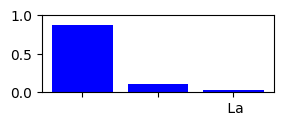


Token scelto: La (id: 2841; probabilità: 0.8928)


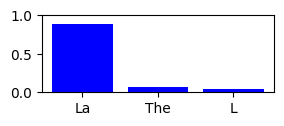


Token scelto:  capitale (id: 66831; probabilità: 0.8818)


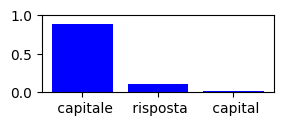


Token scelto:  della (id: 4748; probabilità: 0.9803)


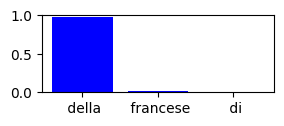


Token scelto:  Francia (id: 35872; probabilità: 0.9990)


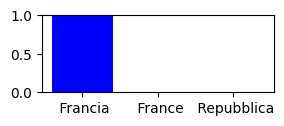


Token scelto:  è (id: 4039; probabilità: 0.9919)


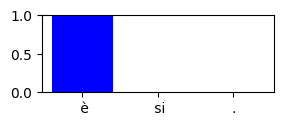


Token scelto:  Parigi (id: 124293; probabilità: 0.7884)


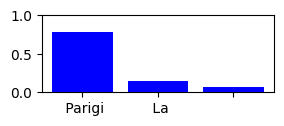


Token scelto: . (id: 235265; probabilità: 0.9284)


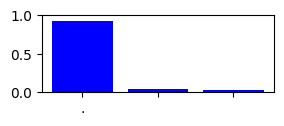


Token scelto:   (id: 235248; probabilità: 0.7907)


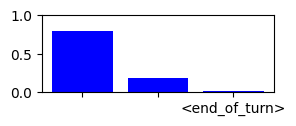


Token scelto: <end_of_turn> (id: 107; probabilità: 0.9949)


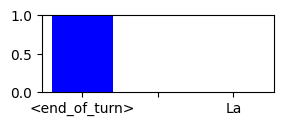

In [18]:
#generated_tokens = generated_ids[len(inputs["input_ids"][0]):] # token generati dopo il prompt
logits = outputs.scores                     # logits per ognuno dei token generati
probs = torch.tensor([])
top_k = 3

for i in range(len(outputs.scores)):
    token_logits = logits[i]                # logits relativi all'i-esimo token
    token_probs = F.softmax(token_logits, dim=-1) # probabilità associate ai logits

    predicted_token_id = torch.argmax(token_probs).item()
    predicted_token = tokenizer.decode(predicted_token_id)
    print(f'\nToken scelto: {predicted_token} (id: {predicted_token_id}; probabilità: {token_probs[0, predicted_token_id].item():.4f})') # type: ignore

    top_k_probs = torch.topk(token_probs, top_k).values.squeeze() # le cinque probabilità più alte
    top_k_token_ids = torch.topk(token_probs, top_k).indices.squeeze()
    top5_tokens = [tokenizer.decode(token_id) for token_id in top_k_token_ids]
    probs = torch.cat((probs, torch.tensor([top_k_probs[0]])))

    plt.figure(figsize=(3, 1))
    plt.ylim(0, 1) 
    plt.bar(top5_tokens, top_k_probs, color='blue')
    #plt.xlabel('Token')
    #plt.ylabel('Probabilità')
    plt.show()

Un indice per valutare il grado con cui il transformer "è convinto" della risposta che ha prodotto è la _Perplexity_ della risposta, che sostanzialmente porta informazione sull'inverso della probabilità media dei token scelti, e quindi sul numero medio di token effettivamente considerati nella scelta (la Perplexity è calcolata da $2^{- \frac{1}{N} \sum_{i=1}^N \log_2 P(t_i|t_1,t_2,...,t_{i-1})}$, dove $t_i$ è il token $i$-esimo della risposta).

In [9]:
print(f'\nDate le probabilità dei token scelti:\n{probs}')

perplexity = 2**(torch.mean(-torch.log2(probs)))
print(f'la Perplexity della risposta è {perplexity.item():.2f}')


Date le probabilità dei token scelti:
tensor([0.8696, 0.8928, 0.8818, 0.9803, 0.9990, 0.9919, 0.7884, 0.9284, 0.7907,
        0.9848, 0.9992])
la Perplexity della risposta è 1.09


Infine, sperimentiamo una strategia di generazione di token alternativa, il _beam search_, in cui si producono contemporaneamente più risposte alternative, generando a ogni iterazione più token e, via via che le successioni si allungano, mantenendo solo quelle la cui probabilità complessiva è maggiore.

In [19]:
prompt = "Proponi un titolo, originale e in italiano, per un testo di introduzione all'intelligenza artificiale? Scrivi una sola proposta, senza giustificazione e senza caratteri di enfatizzazione."
inputs = tokenizer(prompt, return_tensors="pt")

with torch.no_grad():
    outputs = model.generate(
        inputs["input_ids"],
        max_length=100,                     # numero massimo di token nella risposta
        num_beams=5,                        # numero di opzioni da esplorare in parallelo per ogni token
        num_return_sequences=3,             # numero di risposte da generare
        early_stopping=True,                # ferma la generazione quando tutte le ipotesi sono terminate
        no_repeat_ngram_size=4,             # impedisce la ripetizione di n-grammi di lunghezza 4
        length_penalty=0.6                  # controlla la lunghezza delle risposte, favorendo quelle più lunghe
    )

E ora visualizziamo il risultato.

In [20]:
print(f'\nLa richiesta: {prompt}')

responses = [tokenizer.decode(ids, skip_special_tokens=True) for ids in outputs]
for i, text in enumerate(responses):
    print(f'\nRisposta {i + 1}:', text[1+len(prompt):])


La richiesta: Proponi un titolo, originale e in italiano, per un testo di introduzione all'intelligenza artificiale? Scrivi una sola proposta, senza giustificazione e senza caratteri di enfatizzazione.

Risposta 1: 
L'ombra dell'innovazione



Risposta 2: 
L'uomo e la macchina: un'alleanza digitale



Risposta 3: 
L'uomo e la macchina: una nuova era


